### Fitting OCCAM clusters.

This notebook is about finding using PCA those directions along which open clusters vary

**TO DO**

- Incorporate the pca transforms into the latentvector framework somehow.

- Include tools for studying the explained variance in a chosen direction of hyperspace.

- Include tools for plotting cluster breakdowns along random directions.

- Create scatterplot of pred vs true paramters but for occam stars and check if results are consistent with training dataset values

In [1]:
%load_ext autoreload

%autoreload 2
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset
from apoNN.src.utils import generate_loss_with_masking
from apoNN.src.utils import dump
from apoNN.src.utils import load
from apoNN.src.vectors import *

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

## Loading datasets


We load all of our different datasets

In [2]:
n_data=2000

In [3]:
occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = ApogeeDataset(allStar_occam,outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"]

In [4]:
allStar_behaved_restricted =  load("allStar_behaved_restricted")
dataset_behaved_restricted =  ApogeeDataset(filename="behaved_restricted",outputs = ["aspcap","mask","physical","idx"])

In [5]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = Vector(np.array([allStar_behaved_restricted[param] for param in considered_parameters])[:,:n_data].T)

In [6]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/z10/ae_7600.p")


### Creating vectors using the dataset

In [7]:
#z_behaved_restricted = LatentVector(dataset_behaved_restricted,autoencoder,len(dataset_behaved_restricted))
z_behaved_restricted = LatentVector(dataset_behaved_restricted,autoencoder,n_data)

In [8]:
z_occam = OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))

### Setting up the PCA

In [9]:
whitening_pca  = PCA(n_components=10,whiten=True)
cluster_pca = PCA(n_components=9)

In [10]:
whitening_pca.fit(z_behaved_restricted.centered[:1000])

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [11]:
whitening_pca.explained_variance_ratio_

array([0.29584128, 0.21341665, 0.1987981 , 0.1305252 , 0.10892978,
       0.03454534, 0.01257774, 0.00377138, 0.00113305, 0.0004615 ],
      dtype=float32)

In [12]:
cluster_pca.fit(whitening_pca.transform(z_behaved_restricted.centered[1000:1400]))

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [13]:
cluster_pca.fit(whitening_pca.transform(z_occam.cluster_centered))

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [14]:
cluster_pca.explained_variance_ratio_

array([9.91213206e-01, 6.26551142e-03, 1.28370314e-03, 4.44622967e-04,
       3.55447105e-04, 1.96961046e-04, 1.43902580e-04, 6.00583771e-05,
       2.61372777e-05])

### Linear transformation

In [15]:
w = LinearTransformation(z_behaved_restricted,y)

In [16]:
nonlinear_w = NonLinearTransformation(z_behaved_restricted,y)
nonlinear_w.fit(n_epochs=100)

err:0.12272977828979492
err:0.1080789566040039
err:0.12312958389520645
err:0.1128685250878334
err:0.1136244386434555
err:0.1052451953291893
err:0.0849045068025589
err:0.09607435017824173
err:0.08365730196237564
err:0.07581557333469391
err:0.062068723142147064
err:0.063451386988163
err:0.061701081693172455
err:0.04856427013874054
err:0.0637703388929367
err:0.052490491420030594
err:0.044521089643239975
err:0.04236677289009094
err:0.03211690112948418
err:0.04063200578093529
err:0.04176712781190872
err:0.040028735995292664
err:0.05089391767978668
err:0.04770373925566673
err:0.04399082437157631
err:0.04812117666006088
err:0.036699455231428146
err:0.03916408494114876
err:0.038832031190395355
err:0.040472857654094696
err:0.031198954209685326
err:0.0339883416891098
err:0.039342250674963
err:0.029748914763331413
err:0.038668856024742126
err:0.03321646526455879
err:0.02871640957891941
err:0.028411896899342537
err:0.02266780100762844
err:0.028795907273888588
err:0.02863188460469246
err:0.03159673

err:0.016448020935058594
err:0.021634433418512344
err:0.022604765370488167
err:0.023601297289133072
err:0.029728896915912628
err:0.030467616394162178
err:0.0239618718624115
err:0.02782636135816574
err:0.022499533370137215
err:0.023830119520425797
err:0.024899190291762352
err:0.028838546946644783
err:0.024183358997106552
err:0.023168442770838737
err:0.027162712067365646
err:0.020468486472964287
err:0.029506772756576538
err:0.022937888279557228
err:0.020140348002314568
err:0.020425772294402122
err:0.016309328377246857
err:0.021528199315071106
err:0.022517450153827667
err:0.023411700502038002
err:0.029512615874409676
err:0.030289288610219955
err:0.023779738694429398
err:0.02757582999765873
err:0.022325629368424416
err:0.02365577034652233
err:0.024716665968298912
err:0.028657417744398117
err:0.024066070094704628
err:0.023003166541457176
err:0.02699405699968338
err:0.02032543160021305
err:0.029340801760554314
err:0.022771067917346954
err:0.020029131323099136
err:0.02026437409222126
err:0.01

err:0.021415596827864647
err:0.027083244174718857
err:0.028388017788529396
err:0.021889522671699524
err:0.02479630708694458
err:0.020421871915459633
err:0.021733758971095085
err:0.02258867211639881
err:0.026442602276802063
err:0.02241312339901924
err:0.021259265020489693
err:0.02509848028421402
err:0.018764548003673553
err:0.026967672631144524
err:0.02081417106091976
err:0.018893226981163025
err:0.018387824296951294
err:0.014829576946794987
err:0.020352741703391075
err:0.021316131576895714
err:0.021352453157305717
err:0.026999657973647118
err:0.028323333710432053
err:0.021826697513461113
err:0.024697497487068176
err:0.02035827934741974
err:0.021666761487722397
err:0.022511199116706848
err:0.026355909183621407
err:0.022337039932608604
err:0.021205376833677292
err:0.02503443881869316
err:0.018708156421780586
err:0.026865994557738304
err:0.020739713683724403
err:0.018851155415177345
err:0.01831689476966858
err:0.014787912368774414
err:0.020313819870352745
err:0.021262969821691513
err:0.02

err:0.02739235945045948
err:0.021027566865086555
err:0.02336694486439228
err:0.019502008333802223
err:0.020764341577887535
err:0.021540720015764236
err:0.025141248479485512
err:0.021242599934339523
err:0.020486028864979744
err:0.024187784641981125
err:0.01795351505279541
err:0.025324560701847076
err:0.01969034969806671
err:0.01817195490002632
err:0.017327185720205307
err:0.01425706222653389
err:0.01972992718219757
err:0.02045798860490322
err:0.020458921790122986
err:0.025702331215143204
err:0.02735009603202343
err:0.020998677238821983
err:0.0233088918030262
err:0.019470222294330597
err:0.02072576805949211
err:0.02149924449622631
err:0.025085698813199997
err:0.021194634959101677
err:0.02045758068561554
err:0.02415136620402336
err:0.017920812591910362
err:0.025252873077988625
err:0.019645797088742256
err:0.018139952793717384
err:0.017281942069530487
err:0.014236429706215858
err:0.01970255933701992
err:0.020420696586370468
err:0.020419061183929443
err:0.025647828355431557
err:0.0273090377

err:0.020560672506690025
err:0.02241874672472477
err:0.018954725936055183
err:0.02021690458059311
err:0.02094372734427452
err:0.024227166548371315
err:0.020466575399041176
err:0.0200240146368742
err:0.02367604710161686
err:0.01741616614162922
err:0.02413974702358246
err:0.018979787826538086
err:0.01759934239089489
err:0.01663845032453537
err:0.013936208561062813
err:0.019276443868875504
err:0.019806209951639175
err:0.019817302003502846
err:0.02475101128220558
err:0.026674525812268257
err:0.020543964579701424
err:0.02237006649374962
err:0.01892842724919319
err:0.020194970071315765
err:0.020920589566230774
err:0.024182153865695
err:0.020434198901057243
err:0.020000863820314407
err:0.023652834817767143
err:0.01739230751991272
err:0.024083374068140984
err:0.018950631842017174
err:0.01757383719086647
err:0.016610998660326004
err:0.01392309833317995
err:0.01925855688750744
err:0.019773123785853386
err:0.019789835438132286
err:0.024703025817871094
err:0.026642857119441032
err:0.02052376791834

err:0.026194777339696884
err:0.020244315266609192
err:0.021685125306248665
err:0.018527714535593987
err:0.01985681802034378
err:0.020478617399930954
err:0.023445313796401024
err:0.019883763045072556
err:0.01962229050695896
err:0.0232904814183712
err:0.017014479264616966
err:0.023166969418525696
err:0.018472179770469666
err:0.017147045582532883
err:0.01617421582341194
err:0.01371586974710226
err:0.018933961167931557
err:0.019249124452471733
err:0.019311565905809402
err:0.023923886939883232
err:0.026168396696448326
err:0.020230883732438087
err:0.02164948545396328
err:0.01850736513733864
err:0.019839223474264145
err:0.02045552060008049
err:0.02340681478381157
err:0.01985403150320053
err:0.01960410177707672
err:0.02327479049563408
err:0.01699444092810154
err:0.023121321573853493
err:0.018451469019055367
err:0.01712828129529953
err:0.016154835000634193
err:0.013705406337976456
err:0.018916107714176178
err:0.01922958344221115
err:0.019287876784801483
err:0.023887362331151962
err:0.0261450391

Text(0.5, 1.0, 'C_FE')

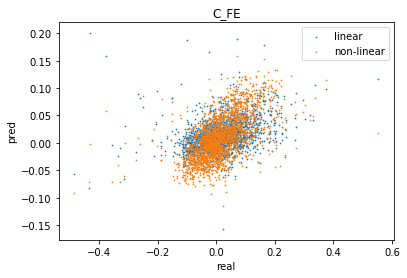

In [20]:
i=4
plt.scatter(y.raw[:,i],w.predict(z_behaved_restricted).raw[:,i],s=0.5,label="linear")
plt.scatter(y.raw[:,i],nonlinear_w.predict(z_behaved_restricted).raw[:,i],s=0.5,label="non-linear")
plt.legend()
plt.xlabel("real")
plt.ylabel("pred")
plt.title(considered_parameters[i])

### Investigating individual clusters

In [34]:
z_occam.registry

{'NGC 7789': array([206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
        219]),
 'Collinder 220': array([31]),
 'King 5': array([39]),
 'NGC 2158': array([67, 68, 69, 70, 71, 72, 73, 74]),
 'Basel 11b': array([0]),
 'Berkeley 17': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'NGC 1798': array([47, 48, 49, 50, 51, 52]),
 'Berkeley 53': array([18, 19, 20, 21]),
 'IC 1369': array([36, 37]),
 'NGC 2243': array([87, 88, 89, 90, 91]),
 'Ruprecht 147': array([220]),
 'Czernik 21': array([32]),
 'Berkeley 98': array([27, 28, 29, 30]),
 'NGC 188': array([53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 'Berkeley 31': array([14]),
 'Czernik 30': array([33, 34]),
 'NGC 2420': array([ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107]),
 'FSR 0496': array([35]),
 'Teutsch 84': array([222]),
 'NGC 6791': array([134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163,

In [35]:
clust_idxs =z_occam.registry['NGC 7789']

In [83]:
len(z_occam.dataset.allStar[clust_idxs]["O_Fe"])

14

(-1, 1)

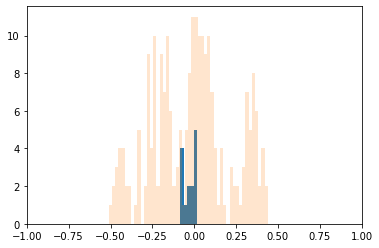

In [91]:
plt.hist(z_occam.dataset.allStar[clust_idxs]["O_Fe"],bins=5)
plt.hist(z_occam.dataset.allStar["Fe_H"],bins=50,alpha=0.2)
plt.xlim(-1,1)

(-1, 1)

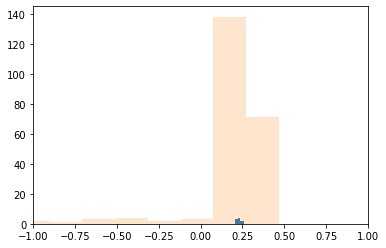

In [92]:
plt.hist(w.predict(z_occam).raw[:,3][clust_idxs],bins=5)
plt.hist(w.predict(z_occam).raw[:,3],bins=50,alpha=0.2)
plt.xlim(-1,1)

(-1, 1)

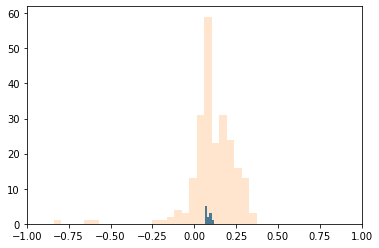

In [93]:
plt.hist(nonlinear_w.predict(z_occam).raw[:,3][clust_idxs],bins=5)
plt.hist(nonlinear_w.predict(z_occam).raw[:,3],bins=50,alpha=0.2)
plt.xlim(-1,1)

### Sandbox

In [ ]:
y.normalized


In [ ]:
nonlinear_w.fit(n_epochs=500)

In [ ]:
i=2
plt.scatter(y.raw[:,i],nonlinear_w.predict(z_behaved_restricted).raw[:,i],s=0.5,label="non_linear")
plt.scatter(y.raw[:,i],w.predict(z_behaved_restricted).raw[:,i],s=0.5,label="linear")
plt.legend()
plt.xlabel("real")
plt.ylabel("pred")
plt.title(considered_parameters[i])

In [ ]:
nonlinear_w.pred()

In [ ]:
y.centered.shape

In [ ]:
np.mean(y.centered,0)

In [ ]:
y.centered/

In [ ]:
plt.hist((y.centered/np.max(y.centered,0))[:,2])

In [ ]:
from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder


In [ ]:
structure = [z_behaved_restricted.centered.shape[1],256,256,y.centered.shape[1]]
structure

In [ ]:
feedforward  = Feedforward(structure,activation=nn.SELU()).to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(feedforward.parameters(),lr=0.0001)

In [ ]:
idx_loader = torch.utils.data.DataLoader(torch.arange(y.centered.shape[0]),batch_size=20)

In [ ]:
for i in idx_loader:
    break

In [ ]:
torch.tensor(y.centered[i])

In [ ]:
z_behaved_restricted,y

In [ ]:
z_behaved_restricted